In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from astroML.datasets import generate_mu_z
from astroML.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression, NadarayaWatson
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, accuracy_score
from astroML.linear_model import BasisFunctionRegression
from sklearn.preprocessing import PolynomialFeatures

C:\Users\Asus\anaconda3\envs\pymc_env\Lib\site-packages\astroML\linear_model\linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

**Linear Regression**

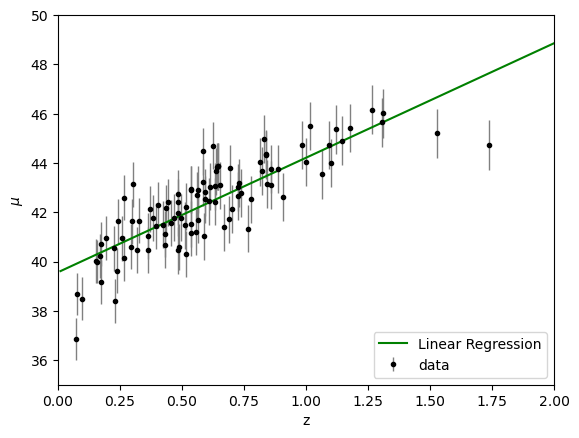

In [3]:
lin_reg = LinearRegression()
lin_reg.fit(z_sample[:,np.newaxis], mu_sample)
z = np.linspace(0.01, 2, 100)
mu_fit = lin_reg.predict(z[:,np.newaxis])
plt.figure(dpi=100)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(z, mu_fit, '-g',label='Linear Regression')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

**Polynomial Regression**

(35.0, 50.0)

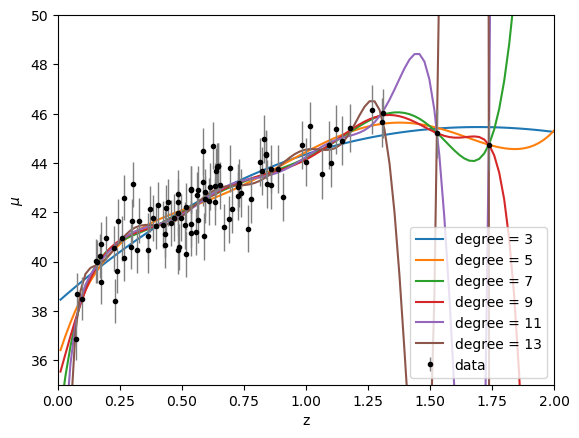

In [4]:
plt.figure(dpi=100)
degrees=np.arange(2,15)[1::2]
for degree in degrees:
    pol_reg = PolynomialRegression(degree)
    pol_reg.fit(z_sample[:,np.newaxis], mu_sample, dmu)
    mu_fit1= pol_reg.predict(z[:,np.newaxis])
    plt.plot(z, mu_fit1, label='degree = {}'.format(degree))
    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

The linear function is underfitting and surely the 13 is overfitting. \
Now I split the data into training and validation sets.

In [5]:
z_train, z_valid, mu_train, mu_valid = train_test_split(z_sample, np.array([mu_sample,dmu]).T, test_size=0.2, random_state=42)
mu_train, dmu_train = mu_train.T
mu_valid, dmu_valid = mu_valid.T

Implementation of a cross-validation procedure.

In [6]:
rmse_t,rmse_v = [], []
degrees=np.arange(2,15)
for degree in degrees:
    pol_reg = PolynomialRegression(degree)
    pol_reg.fit(z_train[:,np.newaxis], mu_train, dmu_train)
    pol_pred = pol_reg.predict(z_train[:,np.newaxis])
    rmse_train = np.sqrt(mean_squared_error(mu_train, pol_pred))
    pol_val = pol_reg.predict(z_valid[:,np.newaxis])
    rmse_valid = np.sqrt(mean_squared_error(mu_valid, pol_val))
    rmse_t.append(rmse_train)
    rmse_v.append(rmse_valid)

In [7]:
print('Best= ', np.argmin(rmse_v)+2) 

Best=  6


Text(0.5, 1.0, 'Polynomial Regression RMSE vs. Polynomial Degree')

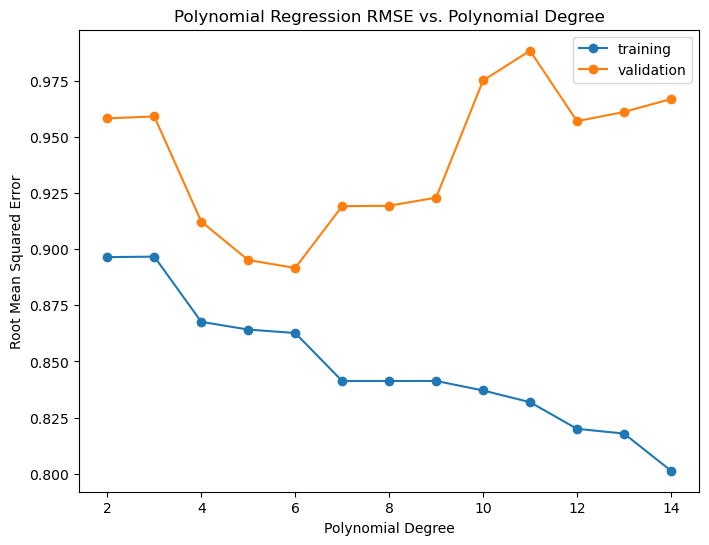

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(degrees, rmse_t, marker='o', linestyle='-', label='training')
plt.plot(degrees, rmse_v, marker='o', linestyle='-', label= 'validation')
plt.legend()
#plt.semilogy()
plt.xlabel("Polynomial Degree")
plt.ylabel("Root Mean Squared Error")
plt.title("Polynomial Regression RMSE vs. Polynomial Degree")

**Basis Function Regression**

(35.0, 50.0)

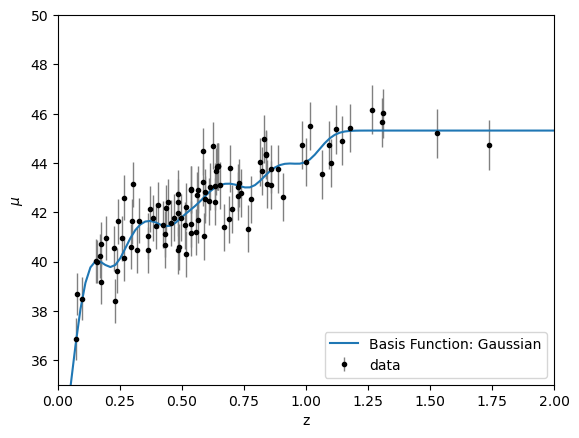

In [9]:
centers = np.linspace(0,1,10)[:, None] 
sigma_test = 0.06

basis_reg = BasisFunctionRegression('gaussian', mu=centers, sigma=sigma_test)
basis_reg.fit(z_train[:, np.newaxis], mu_train, dmu_train)
mu_fit_basis = basis_reg.predict(z[:, np.newaxis])

plt.figure(dpi=100)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(z, mu_fit_basis, label=f'Basis Function: Gaussian')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)

In [10]:
sigma_values = np.linspace(0.01, 1, 20)

n_splits = 5
kf = KFold(n_splits=n_splits)

average_train_mse_values = []
average_val_mse_values = []
best_sigma = None
lowest_mse = float('inf')

for sigma in sigma_values:
    train_mse_list = []
    val_mse_list = []
    for train_index, val_index in kf.split(z_train):
        z_train_fold, z_val_fold = z_train[train_index], z_train[val_index]
        mu_train_fold, mu_val_fold = mu_train[train_index], mu_train[val_index]
        
        basis_reg = BasisFunctionRegression('gaussian', mu=centers, sigma=sigma)
        basis_reg.fit(z_train_fold[:, np.newaxis], mu_train_fold, dmu_train[train_index])
        
        mu_train_pred = basis_reg.predict(z_train_fold[:, np.newaxis])
        mu_val_pred = basis_reg.predict(z_val_fold[:, np.newaxis])
        
        train_mse = np.sqrt(mean_squared_error(mu_train_fold, mu_train_pred))
        val_mse = np.sqrt(mean_squared_error(mu_val_fold, mu_val_pred))
        
        train_mse_list.append(train_mse)
        val_mse_list.append(val_mse)
    
    # averaging of training and validation MSE values across folds is crucial for robust model evaluation and hyperparameter tuning
    average_train_mse = np.mean(train_mse_list)
    average_val_mse = np.mean(val_mse_list)
    
    average_train_mse_values.append(average_train_mse)
    average_val_mse_values.append(average_val_mse)
    
    # Check if this is the best sigma so far (based on validation RMSE)
    if average_val_mse < lowest_mse:
        lowest_mse = average_val_mse
        best_sigma = sigma

print(f'Best sigma: {best_sigma}, Lowest validation MSE: {lowest_mse}')


Best sigma: 0.06210526315789474, Lowest validation MSE: 1.1649455620770368


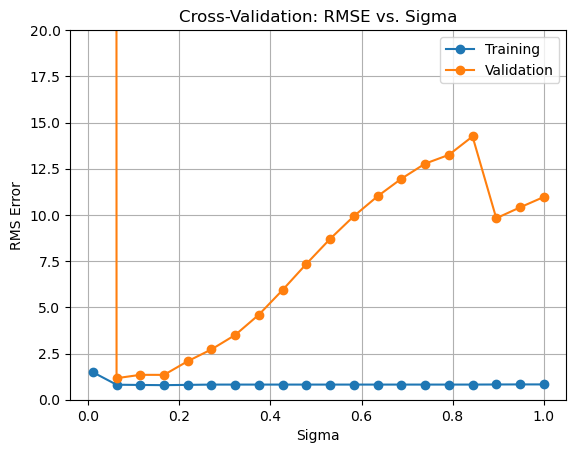

In [11]:
plt.figure(dpi=100)
plt.plot(sigma_values, average_train_mse_values, marker='o', label='Training')
plt.plot(sigma_values, average_val_mse_values, marker='o', label='Validation')
plt.xlabel('Sigma')
plt.ylabel('RMS Error')
plt.ylim(0,20)
plt.title('Cross-Validation: RMSE vs. Sigma')
plt.legend()
plt.grid(True)

**Kernel Regression**

Text(0.5, 1.0, 'Nadaraya-Watson Kernel Regression')

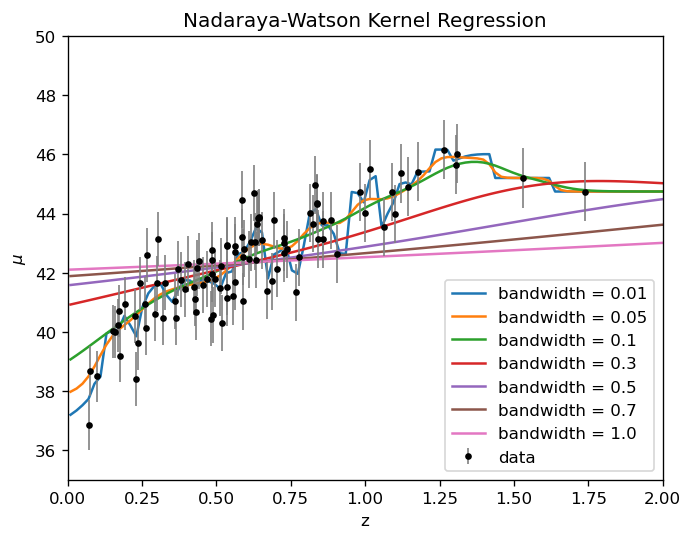

In [12]:
plt.figure(dpi=120)
bandwidths = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0]
for bandwidth in bandwidths:
    nw_reg = NadarayaWatson('gaussian', h=bandwidth)
    nw_reg.fit(z_sample[:, np.newaxis], mu_sample)
    mu_fit = nw_reg.predict(z[:, np.newaxis])
    plt.plot(z, mu_fit, label=f'bandwidth = {bandwidth}')

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title("Nadaraya-Watson Kernel Regression")

In [13]:
k = 5 
kf = KFold(n_splits=k, shuffle=True, random_state=42)

rmse_t = []
rmse_v = []

for b in bandwidths:
    rmse_t_fold = []
    rmse_v_fold = []
    
    for train_index, valid_index in kf.split(z_train):
        z_train_fold, z_valid_fold = z_train[train_index], z_train[valid_index]
        mu_train_fold, mu_valid_fold = mu_train[train_index], mu_train[valid_index]
        dmu_train_fold, dmu_valid_fold = dmu_train[train_index], dmu_train[valid_index]
        
        k_reg = NadarayaWatson('gaussian', h=b)
        k_reg.fit(z_train_fold[:, np.newaxis], mu_train_fold, dmu_train_fold)
        
        k_pred_train = k_reg.predict(z_train_fold[:, np.newaxis])
        k_pred_valid = k_reg.predict(z_valid_fold[:, np.newaxis])
        
        rmse_train = np.sqrt(mean_squared_error(mu_train_fold, k_pred_train))
        rmse_valid = np.sqrt(mean_squared_error(mu_valid_fold, k_pred_valid))
        
        rmse_t_fold.append(rmse_train)
        rmse_v_fold.append(rmse_valid)

    avg_rmse_t = np.mean(rmse_t_fold)
    avg_rmse_v = np.mean(rmse_v_fold)
    
    rmse_t.append(avg_rmse_t)
    rmse_v.append(avg_rmse_v)

In [14]:
best_bandwidth = bandwidths[np.argmin(rmse_v)]
print(f"Best bandwidth: {best_bandwidth}")

Best bandwidth: 0.05


***What happens when you change the number of datapoints?*** I decided to change the splitting of training and validation

In [15]:
t_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
rmse_train_sizes, rmse_val_sizes= [], []
degrees=np.arange(2,15)
for t in t_sizes:
    z_train, z_valid, mu_train, mu_valid = train_test_split(z_sample, np.array([mu_sample,dmu]).T, test_size=t, random_state=42)
    mu_train, dmu_train = mu_train.T
    mu_valid, dmu_valid = mu_valid.T
    rmse_t,rmse_v = [], []
    
    for degree in degrees:
        pol_reg = PolynomialRegression(degree)
        pol_reg.fit(z_train[:,np.newaxis], mu_train, dmu_train)
        pol_pred = pol_reg.predict(z_train[:,np.newaxis])
        rmse_train = np.sqrt(mean_squared_error(mu_train, pol_pred))
        pol_val = pol_reg.predict(z_valid[:,np.newaxis])
        rmse_valid = np.sqrt(mean_squared_error(mu_valid, pol_val))
        rmse_t.append(rmse_train)
        rmse_v.append(rmse_valid)
        
    pol_reg = PolynomialRegression(np.argmin(rmse_v)+2)
    pol_reg.fit(z_train[:,np.newaxis], mu_train, dmu_train)
    pol_pred_best = pol_reg.predict(z_train[:,np.newaxis])
    rmse_train_best = np.sqrt(mean_squared_error(mu_train, pol_pred_best))
    pol_val_best = pol_reg.predict(z_valid[:,np.newaxis])
    rmse_valid_best = np.sqrt(mean_squared_error(mu_valid, pol_val_best))
    rmse_train_sizes.append(rmse_train_best)
    rmse_val_sizes.append(rmse_valid_best)

Here I plot the resulting learning curves

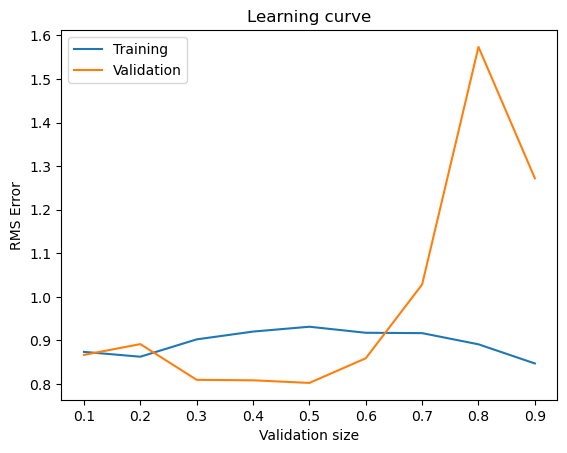

In [17]:
plt.plot(t_sizes, rmse_train_sizes, label='Training')
plt.plot(t_sizes, rmse_val_sizes, label='Validation')
plt.xlabel('Validation size')
plt.ylabel('RMS Error')
plt.title('Learning curve')
plt.legend()

Here we can see that when the validation size overcomes the 20% of the size of the dataset, the error of the training set increases and then the model has an high variance. I guess that the best split for this dataset can be $\sim$ 0.2 for the validation and $\sim$ 0.8 for the training set. 